# Ferromagnetic Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data simulated in oommf from csv

In [2]:
data1 = pd.read_csv("./data/pulse_xsize=1e-06.csv")
data1 = data1[[' Oxs_TimeDriver::Simulation time (s)', ' Oxs_TimeDriver::mx', ' Oxs_TimeDriver::my', ' Oxs_TimeDriver::mz']]
data1.columns = ['Time', 'mx', 'my', 'mz']

## Convert data to numeric type

Sometimes pandas does not read correctly the output file from oommf, so it does not convert correctly the values in the file to floats. This cell converts the values in the file to float in case pandas has not read them correctly

In [3]:
if(type(data1['Time'][0]) == str):
    data1['Time'] = data1['Time'].str.strip()
    data1['mz'] = data1['mz'].str.strip()
    data1['Time'] = pd.to_numeric(data1['Time'], errors='coerce')
    data1['mz'] = pd.to_numeric(data1['mz'], errors='coerce')
    data1 = data1.dropna()

## Find decay rate of magnetization oscillation

This cell find the peaks in the signal to later fit a exponential the shape described by these peaks

In [4]:
decayind = signal.find_peaks_cwt(data1['mz'], np.arange(1,80))
decay = []
x_decay = []
for index in decayind:
    x_decay.append(data1['Time'][index])
    decay.append(data1['mz'][index])

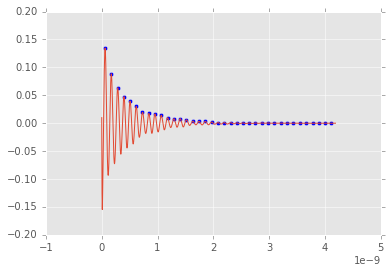

In [5]:
plt.plot(data1['Time'], data1['mz'])
plt.scatter(x_decay, decay)

Define exponential function to fit the peaks defined in the last cell. The last line fits the peaks of the magnetization to an exponential using the scipy.optimize function curve_fit 

In [6]:
def exponential(x, a, b):
    return a * np.exp(-b * x)
popt, pcov = curve_fit(exponential, x_decay, decay)

Show fitted decay 

The decay rate of mz is 2.67e+09


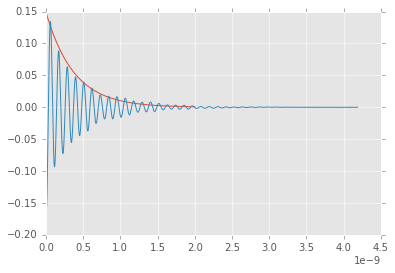

In [7]:
x = np.linspace(0, 2e-9, 1000)
y = exponential(np.array(x), *popt)
plt.plot(x, y)
plt.plot(data1['Time'], data1['mz'])
print('The decay rate of mz is {0:.3g}'.format(popt[1]))
decay_rates = []
decay_rates.append(popt[1])

## Frequency Analysis

* Define the time step used in the simulation
* Define the number of points in the simulation
* Perform the fourier transform to the magnetization values
* Define the frequency space using the scipy.fftpack function fftfreq

+ Use only positive frequency values for the analysis

In [8]:
dt = data1['Time'][1] - data1['Time'][0]
n = len(data1['my']) 
mz_fft = fft(data1['my'])
freq = fftfreq(n, dt)

mask = freq > 0
freq = freq[mask]
mz_fft = mz_fft[mask]

Plot the dominant frequencies present in the magnetization oscillation

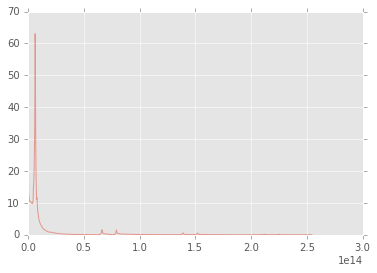

In [9]:
plt.plot(freq, abs(mz_fft), alpha = 0.5)

Define the dominant frequency

In [10]:
max_freq = freq[mz_fft.argmax()]
print('The dominating frequency is {0:.3g} Hz'.format(max_freq))

The dominating frequency is 5.72e+12 Hz


Find the peaks in the fourier transform to determine other present frequencies in the magnetization oscillation

In [11]:
peakind = signal.find_peaks_cwt(abs(mz_fft), np.arange(100,250))
peaks = []
x_peaks = []
for index in peakind:
    x_peaks.append(freq[index])
    peaks.append(abs(mz_fft[index]))  
    
    

In [13]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [14]:
maxtab, mintab = peakdet(abs(mz_fft),.19, freq)
x_peaks = array(maxtab)[:,0]
peaks = array(maxtab)[:,1] 

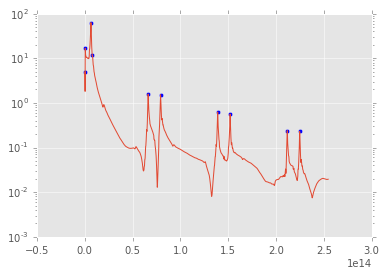

In [15]:
plt.scatter(x_peaks, peaks)
plt.plot(freq, abs(mz_fft))
plt.yscale('log')

In [16]:
mask = np.ones(len(x_peaks), dtype=bool)
mask[[0,1,3]] = False
x_peaks = x_peaks[mask]
peaks = peaks[mask]

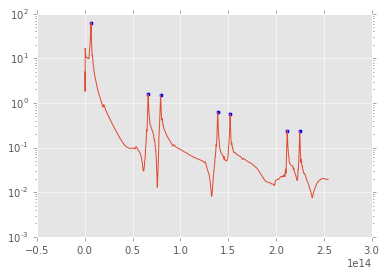

In [17]:
plt.scatter(x_peaks, peaks)
plt.plot(freq, abs(mz_fft))
plt.yscale('log')

Plot the fourier transform along with the detected peaks

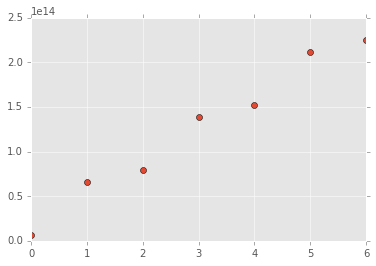

In [18]:
plt.plot(x_peaks, 'o')